# M5 Forecasting Challenge - EDA

This notebook consists of exploratory data analysis for the [M5](https://www.kaggle.com/c/m5-forecasting-accuracy) forecasting challenge. This competition was launched in March 2020. The competition aimed at predicting future sales at the product level, based on historical data.  

**The DataSet**  

calendar.csv - Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.  
sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913].  
submission.csv - Demonstrates the correct format for submission to the competition.  
sell_prices.csv - Contains information about the price of the products sold per store and date.  
sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales for [d_1 - d_1941].  

Lets try to visualize the data and get some insights

Import libraries

In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os #using operating system dependent functionality
import datetime #datetime module supplies classes for manipulating dates and times.
import math # provides access to the mathematical functions
from IPython.display import display, HTML

#For Plotting
# Using plotly + cufflinks in offline mode
import plotly as py
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
init_notebook_mode(connected=True)


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#For time series decomposition
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

#Pandas option
pd.options.display.float_format = '{:.2f}'.format

In [1]:
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from pathlib import Path
from sklearn.utils import shuffle
import tqdm as tqdm
import regex as re

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
pd.plotting.register_matplotlib_converters()
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

## Fetch the data

In [2]:
sales_train_validation = pd.read_csv('../data/sales_train_validation.csv')
calendar = pd.read_csv('../data/calendar.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')
submission = pd.read_csv('../data/sample_submission.csv')

**Calendar dataframe**

In [3]:
#Display first 5 rows of dataframe
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
# Display information about each column in calendar_df.
calendar.shape

(1969, 14)

In [5]:
# Display information about each column in calendar_df.
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [6]:
# Check for missing values.
calendar.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

**Sales dataframe**

In [7]:
#Display first 5 rows of dataframe
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [83]:
sales_train_validation.dept_id.value_counts()

FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64

In [8]:
# Display the information of each column of sales_train_validation.
sales_train_validation.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object

In [9]:
# Display the number of rows and columns for sales_train_valid_df.
sales_train_validation.shape

(30490, 1919)

In [10]:
#Check for missing values.
sales_train_validation.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

**Selling price dataframe**

In [11]:
# Display the first few rows of sell_prices dataframe.
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [12]:
# Display information about each column in sell_prices.
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [13]:
# Number of rows and columns for sell_prices
sell_prices.shape

(6841121, 4)

In [14]:
# Check for missing values.
sell_prices.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

Data is clean with not many missing values other than events, which is expected since events do not occur everyday.

**Submission dataframe**

In [15]:
# Display the first few rows of submission dataframe.
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exporatory Data Analysis & Summary Stats

**Sales data**

In [16]:
# Create a variable for dates.
date_col = [col for col in sales_train_validation if col.startswith('d_')]

CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64


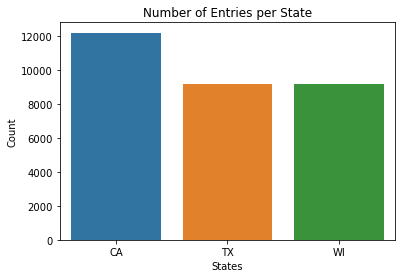

In [17]:
# Count the number of data entries for CA, TX, and WI.
sales_state_count = sales_train_validation.state_id.value_counts()
print(sales_state_count)

# Create bar plot for the state counts.
sns.countplot('state_id', data=sales_train_validation)
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Number of Entries per State')
plt.show()

In [18]:
# Display the percentages for the number of data entries for CA, TX, and WI.
percent_state = sales_train_validation.state_id.value_counts()/sales_train_validation.shape[0] * 100
percent_state

CA    40.0
TX    30.0
WI    30.0
Name: state_id, dtype: float64

In [19]:
# Sum the sales to create a new column called sales.
# Display the total sales for each state.
sales_train_validation['total_sales'] = sales_train_validation[date_col].sum(axis=1)
sales_train_validation.groupby('state_id').agg({'total_sales':'sum'}).reset_index()

,state_id,total_sales
0,CA,28675547
1,TX,18899006
2,WI,18120856


In [20]:
# Display the total sales as percentages for each state.
(sales_train_validation.groupby('state_id').agg({'total_sales':'sum'})/sales_train_validation.total_sales.sum() * 100).reset_index()

,state_id,total_sales
0,CA,43.649240
1,TX,28.767621
2,WI,27.583139


In [21]:
# Display the total sales as percentages for each store.
(sales_train_validation.groupby('store_id').agg({'total_sales':'sum'})/sales_train_validation.total_sales.sum() * 100).reset_index()

,store_id,total_sales
0,CA_1,11.718043
1,CA_2,8.654296
2,CA_3,17.030383
3,CA_4,6.246519
4,TX_1,8.517021
5,TX_2,10.981565
6,TX_3,9.269034
7,WI_1,7.837781
8,WI_2,9.961141
9,WI_3,9.784218


California has the highest sales among the three states. This is in part because it has four stores versus the other two states have three stores. California has a higher population/popuation density among the three states, so this is another explanation for higher sales.

In [22]:
# Display the total sales for each category.
sales_train_validation.groupby('cat_id').agg({'total_sales':'sum'}).reset_index()

,cat_id,total_sales
0,FOODS,45089939
1,HOBBIES,6124800
2,HOUSEHOLD,14480670


In [23]:
# Display the total sales as percentages for each category.
(sales_train_validation.groupby('cat_id').agg({'total_sales':'sum'})/sales_train_validation.total_sales.sum() * 100).reset_index()

,cat_id,total_sales
0,FOODS,68.634840
1,HOBBIES,9.323026
2,HOUSEHOLD,22.042134


In [24]:
# Create a table to display total sales percentages for each category in each state.
sales_train_validation.groupby(['cat_id', 'state_id']).agg({'total_sales':'sum'}).groupby(level=0)\
.apply(lambda x: 100 * x / \
       float(x.sum())).unstack()



total_sales                      
state_id           CA         TX         WI
cat_id                                     
FOODS       42.573360  28.734616  28.692024
HOBBIES     49.632364  25.998220  24.369416
HOUSEHOLD   44.468674  30.041745  25.489580

In [25]:
# Create a table to display total sales percentages for each state in each category.
sales_train_validation.groupby(['state_id', 'cat_id']).agg({'total_sales':'sum'}).\
groupby(level=0).apply(lambda x: 100 * x / \
                       float(x.sum())).unstack()

total_sales                      
cat_id         FOODS    HOBBIES  HOUSEHOLD
state_id                                  
CA         66.943107  10.600959  22.455934
TX         68.556098   8.425517  23.018385
WI         71.394067   8.236796  20.369137

In [26]:
# Display the total sales as percentages for each department.
(sales_train_validation.groupby('dept_id').agg({'total_sales':'sum'})/ \
 sales_train_validation.total_sales.sum() * 100).reset_index()

,dept_id,total_sales
0,FOODS_1,7.744896
1,FOODS_2,11.613935
2,FOODS_3,49.276010
3,HOBBIES_1,8.518799
4,HOBBIES_2,0.804227
5,HOUSEHOLD_1,17.505829
6,HOUSEHOLD_2,4.536305


In [27]:
# Create a table to display total sales percentages for each state in each category.
sales_train_validation.groupby(['store_id', 'dept_id']).\
agg({'total_sales':'sum'}).groupby(level=0).\
apply(lambda x: 100 * x / float(x.sum())).unstack()



total_sales                                                         \
dept_id      FOODS_1    FOODS_2    FOODS_3  HOBBIES_1 HOBBIES_2 HOUSEHOLD_1   
store_id                                                                      
CA_1        7.376371  11.498041  51.022666  10.671615  0.716452   14.291168   
CA_2       12.623167   5.852088  42.737907  10.171235  1.046878   19.468066   
CA_3        6.586076  10.748540  49.841547   7.914764  0.674185   19.190548   
CA_4        8.371275  13.093504  47.240084  13.204210  0.550653   12.937790   
TX_1        6.535066  11.286507  49.703215   6.899086  0.769576   20.478574   
TX_2        7.048641  10.831999  51.634984   7.771571  1.044109   17.384977   
TX_3        6.757065  12.385139  49.224726   7.553655  1.105064   19.053607   
WI_1        9.840666  11.668028  45.267585  11.810365  0.923916   15.981066   
WI_2        8.113585  16.696776  48.052953   5.019734  0.637560   18.562283   
WI_3        6.204706  12.624853  54.767834   6.627481  0.632691   15.831682   

                      
dept_id  HOUSEHOLD_2  
store_id              
CA_1        4.423687  
CA_2        8.100660  
CA_3        5.044341  
CA_4        4.602483  
TX_1        4.327978  
TX_2        4.283720  
TX_3        3.920743  
WI_1        4.508375  
WI_2        2.917110  
WI_3        3.310753

Food category generates the highest sales, household category generates the second highest sales, and hobbies generate lowest sales. People tend to purchase more food than the other categories because food which is quite intuitive.

**Price data**

Text(0.5, 1.0, 'Density plot of log of prices accross Categories')

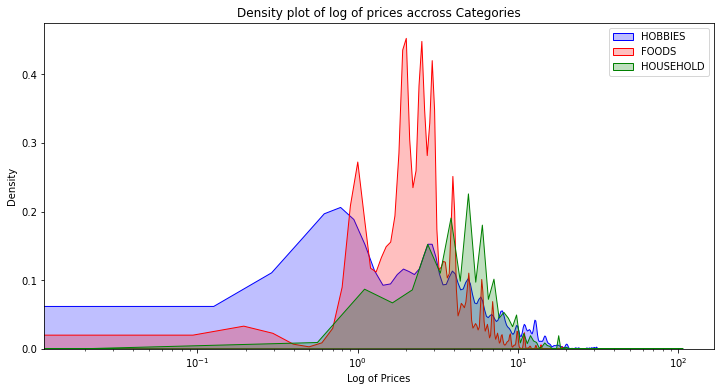

In [30]:
sell_prices["Category"] = sell_prices["item_id"].str.split("_",expand = True)[0]
plt.figure(figsize=(12,6))
p1=sns.kdeplot(sell_prices[sell_prices['Category']=='HOBBIES']['sell_price'], shade=True, color="b")
p2=sns.kdeplot(sell_prices[sell_prices['Category']=='FOODS']['sell_price'], shade=True, color="r")
p3=sns.kdeplot(sell_prices[sell_prices['Category']=='HOUSEHOLD']['sell_price'], shade=True, color="g")
plt.legend(labels=['HOBBIES','FOODS',"HOUSEHOLD"])
plt.xscale("log")
plt.xlabel("Log of Prices")
plt.ylabel("Density")
plt.title("Density plot of log of prices accross Categories")

Food prices vary between 1 and 10. Hobbies have the maximum variability in price. 

In [32]:
#Let's look at items with the maximum price change and minimum price change over the years
item_store_prices = sell_prices.groupby(["item_id","store_id"]).agg({"sell_price":["max","min"]})
item_store_prices.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in item_store_prices.columns]                                               
item_store_prices["price_change"] = item_store_prices["sell_price_max"] - item_store_prices["sell_price_min"]
item_store_prices_sorted = item_store_prices.sort_values(["price_change","item_id"],ascending=False).reset_index()
item_store_prices_sorted["category"] = item_store_prices_sorted["item_id"].str.split("_",expand = True)[0]

In [33]:
print("Items sorted by maximum price change over the years (top 10)")
item_store_prices_sorted.head(10)

Items sorted by maximum price change over the years (top 10)


,item_id,store_id,sell_price_max,sell_price_min,price_change,category
0,HOUSEHOLD_2_406,WI_3,107.32,3.26,104.06,HOUSEHOLD
1,HOUSEHOLD_2_406,WI_2,61.46,12.46,49.00,HOUSEHOLD
2,HOUSEHOLD_2_466,TX_1,52.62,6.46,46.16,HOUSEHOLD
3,HOUSEHOLD_2_178,TX_1,44.36,3.00,41.36,HOUSEHOLD
4,HOUSEHOLD_2_250,WI_2,34.18,3.36,30.82,HOUSEHOLD
5,HOUSEHOLD_2_406,WI_1,35.88,9.97,25.91,HOUSEHOLD
6,HOUSEHOLD_2_250,WI_1,30.32,4.97,25.35,HOUSEHOLD
7,HOUSEHOLD_1_469,WI_3,19.97,1.00,18.97,HOUSEHOLD
8,HOUSEHOLD_2_514,TX_2,19.54,1.00,18.54,HOUSEHOLD
9,HOUSEHOLD_1_342,WI_3,17.97,1.00,16.97,HOUSEHOLD


We see that household items specially HOUSEHOLD_2 department has shown the maximum price changes specially in Wisconsin. The price changed the most for HOUSEHOLD_2_406 item in WI_3 store where the min price was just 3.26 and had rised 32 times to 107

In [34]:
print("Items sorted by least price changes over the years (top 10)")
item_store_prices_sorted.tail(10)

Items sorted by least price changes over the years (top 10)


,item_id,store_id,sell_price_max,sell_price_min,price_change,category
30480,FOODS_1_014,CA_1,0.98,0.98,0.0,FOODS
30481,FOODS_1_014,CA_2,0.98,0.98,0.0,FOODS
30482,FOODS_1_014,CA_3,0.98,0.98,0.0,FOODS
30483,FOODS_1_014,CA_4,0.98,0.98,0.0,FOODS
30484,FOODS_1_014,TX_1,0.98,0.98,0.0,FOODS
30485,FOODS_1_014,TX_2,0.98,0.98,0.0,FOODS
30486,FOODS_1_014,TX_3,0.98,0.98,0.0,FOODS
30487,FOODS_1_014,WI_1,0.98,0.98,0.0,FOODS
30488,FOODS_1_014,WI_2,0.98,0.98,0.0,FOODS
30489,FOODS_1_014,WI_3,0.98,0.98,0.0,FOODS


Interesting observation: FOODS_1_014 item hasnt changed prices over the years. Also, the price is the same in all stores

In [42]:
item_store_prices_sorted

,item_id,store_id,sell_price_max,sell_price_min,price_change,category
0,HOUSEHOLD_2_406,WI_3,107.32,3.26,104.06,HOUSEHOLD
1,HOUSEHOLD_2_406,WI_2,61.46,12.46,49.00,HOUSEHOLD
2,HOUSEHOLD_2_466,TX_1,52.62,6.46,46.16,HOUSEHOLD
3,HOUSEHOLD_2_178,TX_1,44.36,3.00,41.36,HOUSEHOLD
4,HOUSEHOLD_2_250,WI_2,34.18,3.36,30.82,HOUSEHOLD
...,...,...,...,...,...,...
30485,FOODS_1_014,TX_2,0.98,0.98,0.00,FOODS
30486,FOODS_1_014,TX_3,0.98,0.98,0.00,FOODS
30487,FOODS_1_014,WI_1,0.98,0.98,0.00,FOODS
30488,FOODS_1_014,WI_2,0.98,0.98,0.00,FOODS


Text(0.5, 1.0, 'Boxplot for maximum price change for each item over the years across all categories')

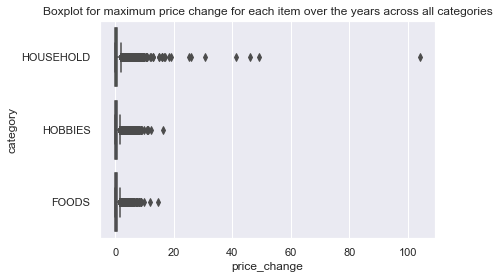

In [48]:
#Plotting boxplot
sns.set(style="darkgrid")
my_pal = {"HOUSEHOLD": "g", "HOBBIES": "b", "FOODS":"m"}
sns.boxplot(x=item_store_prices_sorted["price_change"], y=item_store_prices_sorted["category"], palette=my_pal)
plt.title("Boxplot for maximum price change for each item over the years across all categories")

Most products don't change prices at all and most changes are restricted to 10-15$. Household items have the highest price changes over the years

**Calendar**

In [49]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


From this dataframe we can see the follwoing:  
    
1. The calender data is given for all the 1913 days in the sales data (actually we have 1969 days)
2. We have at max 2 events in a day for which the event names and the event types are given
3. We also SNAP days flags for each state separately i.e. all states have different SNAP days.

What is SNAP?

SNAP stands for the Supplemental Nutrition Assistance Program. SNAP is a federal program that helps millions of low-income Americans put food on the table. Across the United States there are 9.5 million families with children on SNAP. It is the largest program working to fight hunger in America.

What kinds of groceries can be purchased with SNAP?

Households can use SNAP to buy nutritious foods such as breads and cereals, fruits and vegetables, meat and fish and dairy products. SNAP benefits cannot be used to buy any kind of alcohol or tobacco products or any nonfood items like household supplies and vitamins and medicines. N.B. So we can expect SNAP can help sales in food items.

In [51]:
# Event names for each event type
events1 = calendar[['event_type_1','event_name_1',]]
events2 = calendar[['event_type_2','event_name_2',]]
events2.columns = ["event_type_1","event_name_1"]
events = pd.concat([events1,events2],ignore_index = True)
events = events.dropna().drop_duplicates()
events
events_dict = {k: g["event_name_1"].tolist() for k,g in events.groupby("event_type_1")}
print("Event Names across different Event Types")
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in events_dict.items()]))

Event Names across different Event Types


,Cultural,National,Religious,Sporting
0,ValentinesDay,PresidentsDay,LentStart,SuperBowl
1,StPatricksDay,MemorialDay,LentWeek2,NBAFinalsStart
2,Cinco De Mayo,IndependenceDay,Purim End,NBAFinalsEnd
3,Mother's day,LaborDay,OrthodoxEaster,NaN
4,Father's day,ColumbusDay,Pesach End,NaN
5,Halloween,VeteransDay,Ramadan starts,NaN
6,Easter,Thanksgiving,Eid al-Fitr,NaN
7,NaN,Christmas,EidAlAdha,NaN
8,NaN,NewYear,Chanukah End,NaN
9,NaN,MartinLutherKingDay,OrthodoxChristmas,NaN


We have 10 National and Religious events, 6 Cultural Events and 3 Sporting events (30 events in total) in a year

In [53]:
snap_days = calendar.groupby(['year','month'])['snap_CA','snap_TX','snap_WI'].sum().reset_index()
print("SNAP days for each month across the years for all the states")
snap_days.pivot(index="month",columns = "year",values = ["snap_CA","snap_TX","snap_WI"])

SNAP days for each month across the years for all the states


snap_CA                               snap_TX                          \
year     2011  2012  2013  2014  2015  2016    2011  2012  2013  2014  2015   
month                                                                         
1         0.0  10.0  10.0  10.0  10.0  10.0     0.0  10.0  10.0  10.0  10.0   
2        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
3        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
4        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
5        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
6        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
7        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
8        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
9        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
10       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
11       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
12       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   

            snap_WI                                
year   2016    2011  2012  2013  2014  2015  2016  
month                                              
1      10.0     0.0  10.0  10.0  10.0  10.0  10.0  
2      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
3      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
4      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
5      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
6      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
7       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
8       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
9       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
10      NaN    10.0  10.0  10.0  10.0  10.0   NaN  
11      NaN    10.0  10.0  10.0  10.0  10.0   NaN  
12      NaN    10.0  10.0  10.0  10.0  10.0   NaN

So every month we have 10 SNAP days for all the 3 states and it has been consistent througout the years which might fall on different days in different states

Let's look at the unique days at which the 10 SNAP days of a month exists over the years

In [55]:
#Setting the start date
base = datetime.datetime(2011,1,29)
#Calculating the total sales in a day
sales_sum = pd.DataFrame(sales_train_validation[date_col].sum(axis =0),columns = ["sales"])
#Adding the date column
sales_sum['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
sales_sum.set_index('datum', drop=True, inplace=True)
sales_sum.sort_index(inplace=True)

In [57]:
#Joining the calender data with the sales data to see the impact of events
calendar['date'] = pd.to_datetime(calendar['date'])
overall_sales_special = pd.merge(calendar,sales_sum, left_on = "date", right_on = "datum",how = "right")

For CA

In [58]:
overall_sales_special.loc[overall_sales_special.snap_CA==1,"date"].dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

We can see that we 10 unique values. So, all the years SNAP days fall on the sam 10 days i.e. 1st of every month to 10th of every month in CA

For TX

In [59]:
overall_sales_special.loc[overall_sales_special.snap_TX==1,"date"].dt.day.unique()

array([ 1,  3,  5,  6,  7,  9, 11, 12, 13, 15])

We also see 10 unique values dates that means in TX also SNAP falls on the same dates over the months. These dates are different from CA

For WI

In [60]:
overall_sales_special.loc[overall_sales_special.snap_WI==1,"date"].dt.day.unique()

array([ 2,  3,  5,  6,  8,  9, 11, 12, 14, 15])

We also see 10 unique values dates that means in WI also SNAP falls on the same dates over the months. These dates are different from CA and TX

## Time Series Analysis

In [1]:
#High level - daily sales
sales_sum.iplot(title = "Daily Overall Sales")

NameError: name 'sales_sum' is not defined

We see an increasing overall trend and sales are zero on certain day of the year, probably christmas.

Plotting monthly sales time series across the 3 states

In [76]:
state_level = sales_train_validation.groupby("state_id")[date_col].sum().reset_index().set_index('state_id').T
state_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
state_level.set_index('datum', drop=True, inplace=True)
state_level.sort_index(inplace=True)
state_level.head()
state_month_level = state_level.groupby(pd.Grouper(freq='1M')).sum()
state_month_level.iplot(title = "Monthly Sales accross States")

CA sales has always been the highest, maybe duee to higher population/density. The peaks in August are the most evident at CA in comparison to other states. Seasonality impacts CA sales the most.  
WI have shown the highest increase in sales over the years.The sales were lower than TX before 2013. TX and WI sales were similar in 2013 to 2015 August. It has shown higher sales after 2015 August than TX. It will be interesting to look at what has caused WI to increase significantly over the years.

Let's look at store level sales

In [78]:
store_level = sales_train_validation.groupby("store_id")[date_col].sum().reset_index().set_index('store_id').T
store_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
store_level.set_index('datum', drop=True, inplace=True)
store_level.sort_index(inplace=True)
store_level.head()
store_month_level = store_level.groupby(pd.Grouper(freq='1M')).sum()
store_month_level.head()

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
datum,,,,,,,,,,
2011-01-31,11308,8661,13351,4788,7065,10520,8261,6460,6196,11553
2011-02-28,89434,67686,119792,41189,62534,84900,64581,46592,51708,97959
2011-03-31,93468,73964,127344,44902,66890,89902,68370,49747,51113,97867
2011-04-30,91553,72803,122428,44220,66435,87683,66563,46898,47651,91479
2011-05-31,87988,68305,120711,44562,67920,86128,67572,45269,45487,85620


Plotting monthly sales time series across different stores

In [80]:
cf.Figure(cf.subplots([store_month_level[['CA_1','CA_2','CA_3','CA_4']].figure(), \
                       store_month_level[['TX_1','TX_2','TX_3']].figure(), \
                       store_month_level[['WI_1','WI_2','WI_3']].figure()], \
                      shape=(1,3),subplot_titles=('CA', 'TX', 'WI'))).iplot()

In CA, CA_1 and CA_3 shows the highest seasonality in sales and have an increasing trend overall.CA_2 shows a stark decrease in 2015 but has then peaked up in 2016. CA_4 shows a similar increasing trend. Overall, CA stores show the same trend  

In TX, TX_2 was really performing well till 2014 but has dipped after that drastically which is bad.TX_1 shows a moderate increasing trend. The good news in TX is TX_3 is consistently showing an increasing trend  

In WI, WI_1 and WI_2 shows drastic increase in 2012 and 2013 from 50k sales to 100k sales. WI_3 which was the best store in 2012 dipped a lot during 2014 and 2015 but has increased a bit in 2016  


Plotting time series across categories

In [82]:
cat_level = sales_train_validation.groupby("cat_id")[date_col].sum().reset_index().set_index('cat_id').T
cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
cat_level.set_index('datum', drop=True, inplace=True)
cat_level.sort_index(inplace=True)
cat_level.head()
cat_level_level = cat_level.groupby(pd.Grouper(freq='1M')).sum()
cat_level_level.iplot(title = "Monthly Sales accross Categories")

Food sales have always remained much higher than household and hobbies  
Hobbies show a preety much flat trend and less seasonality  
Food show the highest seasonality and household tend the show the highest increase in sales overall  

Plotting monthly sales accross departments

In [84]:
dept_level = sales_train_validation.groupby("dept_id")[date_col].sum().reset_index().set_index('dept_id').T
dept_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
dept_level.set_index('datum', drop=True, inplace=True)
dept_level.sort_index(inplace=True)
dept_level.head()
dept_monthly_level = dept_level.groupby(pd.Grouper(freq='1M')).sum()

In [85]:
cf.Figure(cf.subplots([dept_monthly_level[['FOODS_1','FOODS_2','FOODS_3']]. \
                       figure(),dept_monthly_level[['HOBBIES_1','HOBBIES_2']].figure(), \
                       dept_monthly_level[['HOUSEHOLD_1','HOUSEHOLD_2']].figure()],shape=(1,3),subplot_titles=('FOODS', 'HOBBIES', 'HOUSEHOLD'))).iplot()

FOODS_3 has the highest sales with a high seasonlity, could be produce. FOODS_2 sales has also increased over the years, while FOODS_1 has pretty much remained stagnant over the years.
HOUSEHOLD_1 has shown the best increase in sales over the years as compared to other departments  

Plotting sales for each category in each of the state

In [86]:
dept_cat_level = sales_train_validation.groupby(["state_id","cat_id"])[date_col].sum().reset_index().set_index(["state_id","cat_id"]).T
dept_cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
dept_cat_level.set_index('datum', drop=True, inplace=True)
dept_cat_level.sort_index(inplace=True)
dept_cat_level.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in dept_cat_level.columns]
dept_cat_monthly_level = dept_cat_level.groupby(pd.Grouper(freq='1M')).sum()
cf.Figure(cf.subplots([dept_cat_monthly_level[['CA_FOODS','TX_FOODS','WI_FOODS']].figure(),dept_cat_monthly_level[['CA_HOBBIES','TX_HOBBIES','WI_HOBBIES']].figure(),dept_cat_monthly_level[['CA_HOUSEHOLD','TX_HOUSEHOLD','WI_HOUSEHOLD']].figure()],shape=(1,3),subplot_titles=('FOODS', 'HOBBIES', 'HOUSEHOLD'))).iplot()

Sales of Food items in CA have shown very less of an increase over the years although it has a high monthly seasonality peaking at August each year and dipping towards Year end and start (Nov, Dec, Jand and Feb)  
Sales of Food items in TX also shows a similar trend although at a lower scale (High monthly seasonality peaking at August and dipping at Jan, Feb and overall trend remaining somewhat same)  
Sales of Food items in WI has quite surpassed that of WI in 2015 and 2016. It's the only state showing an increase in Food items over the years. Also we dont see an obvious monthly seasonality in Food items at WI where peaks are at the month of March or July  
Sales of Hobbies items doesnt show any monthly seasonalities as such  
Rather in case of CA, sales of Hobbies items tends to increase every alternate year and dip at alternate year (aka cyclicity) with the dip in Nov,2012 as the worst but increase back quite well. Sales of Hobbies items at CA also shows an increasing trend  
The sales of Hobbies items in TX and WI both show an increasing trend and have quite similar sales with a bit better sales increase in TX  
Household sales shows the best increasing trend in all the states.  
CA shows the best increase in Household items over the years and also has a monthly seasonality again peaking at August and dipping at December and January  
TX shows a bit better sales than WI in Household throughout the years but both show similar increasing trend. They show an increase in sales of Household in August but it's not that evident enough to show a monthly seasonality. Infact, both also show a peak in Mar, 2013  

Let's look at weekly patterns

<AxesSubplot:xlabel='datum', ylabel='sales'>

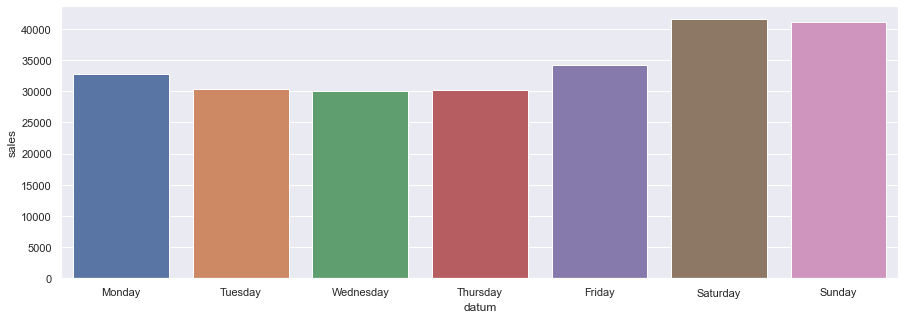

In [95]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
sales_sum_weekday = sales_sum.groupby(sales_sum.index.strftime("%A")).mean().reindex(days)
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x= sales_sum_weekday.index, y='sales', data=sales_sum_weekday)

As expected we can see that weekends have higher sales than weekdays as most people do groceries/shopping on weekdays.

Plotting sales over the week for the 3 categories

In [97]:
cat_level = sales_train_validation.groupby("cat_id")[date_col].sum().reset_index().set_index('cat_id').T
cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
cat_level.set_index('datum', drop=True, inplace=True)
cat_level.sort_index(inplace=True)
cat_level.head()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
sales_cat_weekday = cat_level.groupby([cat_level.index.strftime("%A")]).mean().reindex(days)
sales_cat_weekday.iplot( kind="bar",title = "Avg. Sales across day of week")

Sunday followed by Saturday are the dominant days for sales of Food Items  
Saturday has more sales than Sunday in the case of Household and Hobbies although the differences are quite small  
We do see a sense of weekly seasonality with highest sales in Saturday and Sunday and lowest sales in Wednesday and Thursday

### Impact of Events and SNAP days on sales

In [98]:
overall_sales_special.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,32631
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,31749
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,23783
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,25412
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,19146


Plotting daily sales for the year 2012 to see the pattern of impact of events


In [100]:
overall_sales_special[overall_sales_special.year == 2012].\
groupby("date")["sales"].sum().iplot(title = "Daily Overall Sales")

In [101]:
print("Event days in 2012")
overall_sales_special[(overall_sales_special.year == 2012) & \
                      ((overall_sales_special.event_name_1.notnull()) | \
                       (overall_sales_special.event_name_2.notnull()))]

Event days in 2012


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
337,2012-01-01,11149,Sunday,2,1,2012,d_338,NewYear,National,NaN,NaN,1,1,0,21807
343,2012-01-07,11150,Saturday,1,1,2012,d_344,OrthodoxChristmas,Religious,NaN,NaN,1,1,0,37143
352,2012-01-16,11151,Monday,3,1,2012,d_353,MartinLutherKingDay,National,NaN,NaN,0,0,0,30548
372,2012-02-05,11202,Sunday,2,2,2012,d_373,SuperBowl,Sporting,NaN,NaN,1,1,1,40075
381,2012-02-14,11203,Tuesday,4,2,2012,d_382,ValentinesDay,Cultural,NaN,NaN,0,0,1,25100
387,2012-02-20,11204,Monday,3,2,2012,d_388,PresidentsDay,National,NaN,NaN,0,0,0,30218
389,2012-02-22,11204,Wednesday,5,2,2012,d_390,LentStart,Religious,NaN,NaN,0,0,0,24115
396,2012-02-29,11205,Wednesday,5,2,2012,d_397,LentWeek2,Religious,NaN,NaN,0,0,0,24802
404,2012-03-08,11206,Thursday,6,3,2012,d_405,Purim End,Religious,NaN,NaN,1,0,1,29759
413,2012-03-17,11208,Saturday,1,3,2012,d_414,StPatricksDay,Cultural,NaN,NaN,0,0,0,37904


In [103]:
#Function for tagging events to the preceding weekend 
event_days_sales = overall_sales_special[((overall_sales_special.event_name_1.notnull()) | (overall_sales_special.event_name_2.notnull()))]
overall_sales_special["weekend_precede_event"] = np.nan

def update_weekend_precede_event(week_e,wday,e1,e2):
    e2 = '_' + e2 if type(e2) == str else ''
    drift = e1 + e2
    if wday == 1:
        overall_sales_special.loc[(overall_sales_special['wm_yr_wk']==week_e)&(overall_sales_special['wday']==1),"weekend_precede_event"] = drift
    else:
        overall_sales_special.loc[(overall_sales_special['wm_yr_wk']==week_e)&((overall_sales_special['wday']==1)|(overall_sales_special['wday']==2)),"weekend_precede_event"] = drift
        
_ = event_days_sales.apply(lambda row : update_weekend_precede_event(row['wm_yr_wk'],row['wday'],row['event_name_1'], row['event_name_2']),axis = 1)

In [104]:
print("Events data with added weekend_prece_event column which marks the weekend before each of the event along with the event name")
overall_sales_special.head(10)

Events data with added weekend_prece_event column which marks the weekend before each of the event along with the event name


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales,weekend_precede_event
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,32631,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,31749,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,23783,NaN
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,25412,NaN
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,19146,NaN
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,29211,NaN
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,28010,NaN
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,37932,SuperBowl
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,32736,SuperBowl
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,25572,NaN


We can see that Super Bowl event was on Sunday and we have mapped it to the previous Saturday and Sunday via the column weekend_precede_event

First let's look at impact of different types of events and then we will look at specific events


In [106]:
#adding event type column
events.columns = ["weekend_precede_event_type","weekend_precede_event"]
overall_sales_special = pd.merge(overall_sales_special,events,how= "left",on="weekend_precede_event")

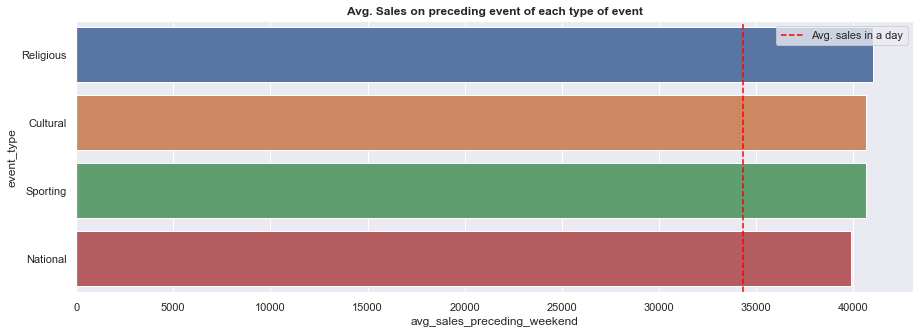

In [107]:
#Calculating sales impact of each event on preceding weekend
event_type_impact = overall_sales_special.groupby(['weekend_precede_event_type'])['sales'].mean().reset_index()
event_type_impact = event_type_impact.sort_values("sales",ascending = False)
event_type_impact.columns = ["event_type","avg_sales_preceding_weekend"]
#Plotting a bar graph of avg. sales on the weekend days before the event to see the impact
chart = sns.barplot(y= "event_type", x='avg_sales_preceding_weekend', data=event_type_impact)
chart.axvline(sales_sum.sales.mean(),label = "Avg. sales in a day",c='red', linestyle='dashed')
plt.title("Avg. Sales on preceding event of each type of event", fontweight ="bold")
leg = plt.legend()


Weekends before all the event types have much higher sales than the avg. sales per day  
Religious events have the highest impact to sales of the preceding weekend, probably due to Christmas  
National events have the lowest impact to sales of the preceding weekend  

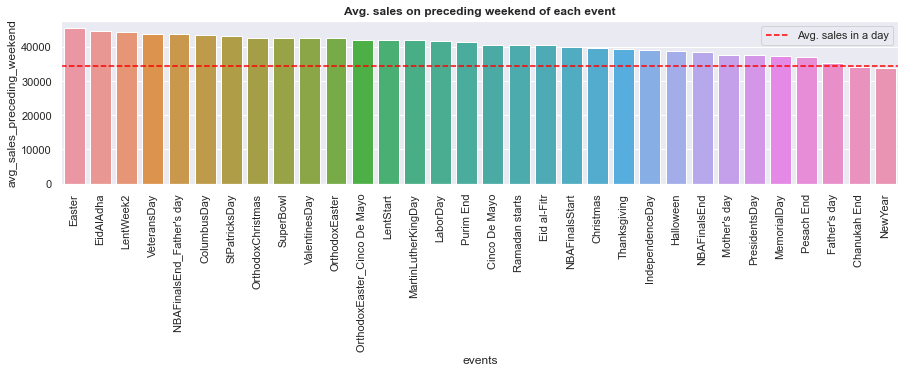

In [108]:
#Calculating sales impact of each event on preceding weekend
event_impact = overall_sales_special.groupby(['weekend_precede_event'])['sales'].mean().reset_index()
event_impact = event_impact.sort_values("sales",ascending = False)
event_impact.columns = ["events","avg_sales_preceding_weekend"]
# Plotting a bar graph of avg. sales on the weekend days before the event to see the impact
sns.set(rc={'figure.figsize':(15,3)})
chart = sns.barplot(x= "events", y='avg_sales_preceding_weekend', data=event_impact)
chart.axhline(sales_sum.sales.mean(),label = "Avg. sales in a day",c='red', linestyle='dashed')
var = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title("Avg. sales on preceding weekend of each event",fontweight = "bold")
leg = plt.legend()

Almost all weekends have higher sales than the average sales  
The highest sales is in the weekend before Easter as expected about 44k each day followed by EidAlAdha which are both  Religious events (which follows our event type finding of religious event having the highest impact)   
The lowest sales is in the weekend before New Year  

Impact of SNAP days

Different states have different SNAP dates so we will have to view them separately

In [110]:
#Joining the state wise sales with the events table
overall_sales_special = pd.merge(overall_sales_special,state_level.reset_index(),how = "left",left_on="date",right_on="datum")
overall_sales_special.drop("datum",axis = 1,inplace =True)

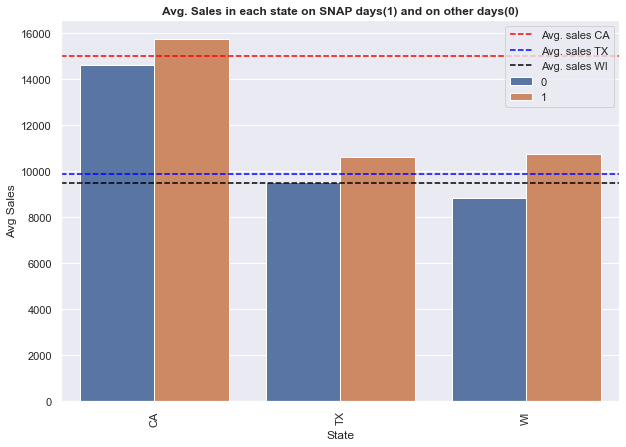

In [111]:
#Comparing the days with and w/o SNAP for all 3 states
ca_snap = overall_sales_special.groupby("snap_CA")["CA"].mean().reset_index()
tx_snap = overall_sales_special.groupby("snap_TX")["TX"].mean().reset_index()
wi_snap = overall_sales_special.groupby("snap_WI")["WI"].mean().reset_index()
ca_snap.columns = ["Snap","CA"]
tx_snap.columns = ["Snap","TX"]
wi_snap.columns = ["Snap","WI"]
snap_impact = pd.merge(ca_snap,tx_snap,on = "Snap")
snap_impact = pd.merge(snap_impact,wi_snap,on = "Snap")
snap_impact = pd.melt(snap_impact, id_vars=['Snap'], value_vars=['CA','TX','WI'],var_name='State', value_name='Avg Sales')
#Plotting bar plots for sales comparison
sns.set(rc={'figure.figsize':(10,7)})
chart=sns.barplot(x= "State", y='Avg Sales',hue = 'Snap' ,data=snap_impact)
chart.axhline(overall_sales_special.CA.mean(),label = "Avg. sales CA",c='red', linestyle='dashed')
chart.axhline(overall_sales_special.TX.mean(),label = "Avg. sales TX",c='blue', linestyle='dashed')
chart.axhline(overall_sales_special.WI.mean(),label = "Avg. sales WI",c='black', linestyle='dashed')
var = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title("Avg. Sales in each state on SNAP days(1) and on other days(0)",fontweight="bold")
leg = plt.legend()

All the states have higher sales on SNAP days. We can see the max increase in WI (~2k more sales on each day) while CA and TX have ~1k more sales on each day of SNAP  
We have seen higher sales during the first 10-15 days of a month.We have also seen that SNAP days fall in the first 15 days. So, there might be a combined effect.  

### Analysis on prices changes

In [113]:
#Sales data of each item at a weekly level
item_sales = sales_train_validation.groupby("item_id")[date_col].sum().reset_index().set_index('item_id').T
#Setting the start date
base = datetime.datetime(2011,1,29)
#Adding the date column
item_sales['date'] = [base + datetime.timedelta(days=x) for x in range(1913)]
item_sales = pd.merge(item_sales,overall_sales_special[["date","wm_yr_wk"]],on = "date")
item_sales=item_sales.groupby(["wm_yr_wk"]).sum().reset_index()
item_sales['date'] = [base + datetime.timedelta(days=x) for x in range(0,1913,7)]
item_sales = item_sales.melt(id_vars=['wm_yr_wk',"date"], value_vars=item_sales.columns.drop(["wm_yr_wk","date"]), var_name='item_id', value_name='sales')
item_sales.head()


,wm_yr_wk,date,item_id,sales
0,11101,2011-01-29,FOODS_1_001,57
1,11102,2011-02-05,FOODS_1_001,63
2,11103,2011-02-12,FOODS_1_001,91
3,11104,2011-02-19,FOODS_1_001,79
4,11105,2011-02-26,FOODS_1_001,76


Distribution of median prices of items over the years

In [116]:
item_mean_prices = sell_prices.groupby("item_id")["sell_price"].median().reset_index()
item_mean_prices.describe()

,sell_price
count,3049.00
mean,4.46
std,3.54
min,0.20
25%,2.24
50%,3.42
75%,5.88
max,29.97


Let's use a threshold of 3.42 to as the median to bucket each item as Cheap or Costly

In [118]:
labels = ["Cheap","Costly"]
#Bucketing each item as cheap or costly
item_mean_prices["item_price_bucket"] =  pd.cut(item_mean_prices.sell_price, [0,3.42,np.inf], include_lowest=True,labels = labels)
item_mean_prices.head()
#Joining with the actual table
price_data_bucketed = pd.merge(sell_prices,item_mean_prices[["item_id","item_price_bucket"]], on = "item_id",how = "left")
#Joining with Sales data
price_data_bucketed = pd.merge(price_data_bucketed,item_sales,on = ["wm_yr_wk","item_id"],how = "left")

base = datetime.datetime(2011,1,29)
#Adding the date column

price_data_bucketed.head()

,store_id,item_id,wm_yr_wk,sell_price,Category,item_price_bucket,date,sales
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES,Costly,2013-07-13,8.00
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES,Costly,2013-07-20,7.00
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES,Costly,2013-07-27,17.00
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES,Costly,2013-08-03,16.00
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES,Costly,2013-08-10,21.00


Let's look at the changes in prices over the weeks for each Category and Price Bucket level

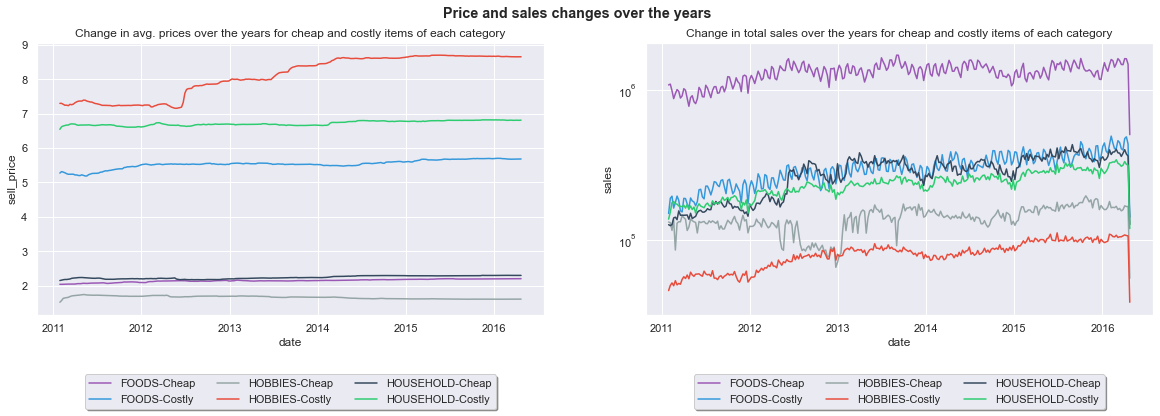

In [119]:
#Creating table at category, price bucket level
mean_table = price_data_bucketed.groupby(["date","Category","item_price_bucket"]).agg({"sell_price":"mean","sales":"sum"}).reset_index()
mean_table["cat-bucket"] = mean_table["Category"].astype(str) + '-'+mean_table["item_price_bucket"].astype(str)


#PLotting the graph
sns.set(rc={'figure.figsize':(20,5)})
fig, (ax1, ax2) = plt.subplots(1,2)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
prices_plot = sns.lineplot(x = "date",y = "sell_price",hue = "cat-bucket",data = mean_table,ax =ax1)
sales_plot = sns.lineplot(x = "date",y = "sales",hue = "cat-bucket",data = mean_table,ax=ax2)
ax1.title.set_text("Change in avg. prices over the years for cheap and costly items of each category")
ax2.title.set_text("Change in total sales over the years for cheap and costly items of each category")
fig.suptitle('Price and sales changes over the years',fontweight="bold")
ax2.set_yscale('log')
leg = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=3)
leg = ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=3)

The prices for products in the cheaper products have increased very less over the years for all the 3 Categories
In the costlier bucket, we could see increase in avg.prices specially in HOBBIES in 2012 and 2013. FOODS also show some increase in prices  
The increase in prices in Costly Hobbies product didnt impact the sales in 2012 and 2013, it actually grew quite well in those years.What we actually see is a dip in sales of Cheaper Hobbies products between 2012 and 2013  
The gap between the selling price of cheaper products and costlier products of Food products is lowest, but the same gap is the highest when compared in terms of sales (i..e Betwee Cheaper Food and and Costlier Food).  
The gap between the selling price of cheaper products and costlier products of Hobbies products is highest, but gap is quite low when compared in terms of sales (i..e Betwee Cheaper Hobbies products and and Costlier Hobbies products).  

### Reduce memory

In [ ]:
#Function to reduce memory usage.
#From: https://www.kaggle.com/ragnar123/very-fst-model
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df 

sales = reduce_mem_usage(sales)
prices = reduce_mem_usage(prices)
calendar = reduce_mem_usage(calendar)

In [ ]:
sales.head()

Melt the dataframe to shape the data such that each row is depicts each item sold per store per day.

In [ ]:
sales_df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [ ]:
sales_df.head()

In [ ]:
sales_df.shape

Merge the calendar and price dataframes to create a single dataframe.

In [ ]:
sales_df = pd.merge(sales_df, calendar, on='d', how='left')
sales_df = pd.merge(sales_df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [ ]:
sales_df.head()

In [ ]:
calendar.head()

In [ ]:
prices.head()